# X-ray surveyor ray-tracing

In this jupter notebook, I do the ray-tracing for the X-ray surveyor. This format allows me to keep the cdoe that I run very close to the figures and tables that I produce.
When you read it, feel free to skip all the code sections. I add some comments for my own benefit (to help me see what I did when I come back in a few weeks to tweak parameters), but I do not intend for this to be a complete introduction to python or MARXS. 
See the https://marxs.readthedocs.org for the documention of MARXS and use Google for any python specific question or talk to me.

In the first section, I set up the code, import moduels etc. This section can be skipped, unless you want to use this as an example of how to run MARXS.

The second section looks at individual runs in more detail. I will present simulated detector images and stuff like that.
In the third section I will calculate the spectral resolution we expect. Then I perform some parameters studies, e.g. how does the resolution change when we introduce a random alignment error to the gratings?
The calcualtions in this section are all performed in parallel on several cores. I do not retain the full simulated event list for each simulations, but just the spectal resolution, but if any case is particulalry interesting, we can always simulate is again.

For reference: Running all simulations shown here takes about 10 min on my office PC.


## Module imports and set-up

In [1]:
import os
from functools import partial
from IPython.parallel import Client, require  # For parallel execution of jobs

# Import python modules needed for the simulation itself
import numpy as np

from marxs.source import FixedPointing, PointSource
from marxs.design import RowlandTorus, GratingArrayStructure
import marxs.optics
from marxs.optics import MarxMirror, FlatGrating, EfficiencyFile, FlatDetector
from marxs.design.rowland import design_tilted_torus
from marxs.analysis import fwhm_per_order, weighted_per_order
from marxs.simulator import Sequence

# Plot shall be embedded in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# Set a default plotting style the modifies matplotlib defaults
import matplotlib as mpl
from astropy.visualization import astropy_mpl_style
mpl.rcParams.update(astropy_mpl_style) 
mpl.rcParams['axes.labelcolor'] = 'k'

In [4]:
# Set up parallel execution of jobs
rc = Client()
dview = rc[:]

In [5]:
# Set up parallel execution of jobs
rc = Client()
dview = rc[:]
with dview.sync_imports():
    import numpy
    import transforms3d

importing numpy on engine(s)
importing transforms3d on engine(s)


In [6]:
def run_res_sim(energy, gas, n_photons=1e5, orders=numpy.arange(-10, 0)):
    '''Calculate the FWHM for a specific energy
    
    This routine runs photons through the model up to te mirror. Then, it loops over the spectral orders
    and calculates the FWHM in every order. In each case, all ``n_photons`` photons will be send into one
    specific order. This reduces the computation time compared to a real efficiency table, were very large 
    photon numbers would be required to find enough photons in all orders.
    
    Note: The model for the satellite (pointing, mirror) is hardcoded in this method, because the C code
    required for the marx mirror cannot be pickeled and passed to the remote worker instance. Instead,
    the satellite model is made in this function, which is executed on the remote workers.
    
    Parameters
    ----------
    energy : float
        monochromatic photon energy in keV
    gas : `marxs.design.rowland.GratingArrayStructure`
        The GAS. This will be used several times (once per order), so the ``order_selector`` will be reset.
    n_photons : int
        Number of photons simulated. Note that this is not the number of photons *detected* because a certain fraction
        will be lost in the mirror.
    orders : np.array
        List of spectral orders. Do not include the zeroth order in the list - it does not have a 
        spectral resolution for a grating.
        
    Returns
    -------
    fwhm, det_x, res : np.array
        see `fwhm_per_order` for details.
    '''
    # Import within the function here to make sure the module is loaded on the engines
    # for parallel execution
    import os
    
    import marxs
    from marxs.source import PointSource, FixedPointing
    from marxs.optics import MarxMirror
    from marxs.simulator import Sequence
    from marxs.analysis import fwhm_per_order
    
    mysource = PointSource((30., 30.), energy=energy, flux=1.)
    photons = mysource.generate_photons(n_photons)
    
    # make model for satellite up to the GAS
    mypointing = FixedPointing(coords=(30, 30.))
    hrmafile = os.path.join(os.path.dirname(marxs.optics.__file__), 'hrma.par')
    marxm = MarxMirror(hrmafile, position=numpy.array([0., 0,0]))
    prune = lambda photons: photons[(photons['probability'] > 0) & (photons['mirror_shell'] == 0)]
    satellite = Sequence(sequence=[mypointing, marxm, prune])
    
    photons = satellite(photons)

    return fwhm_per_order(gas, photons, orders)


In [7]:
# Define the same function on the remote engines.
# Yes, this look a little odd, but we need this step to run an interactively defined function on remote instances for
# parallel execution.
dview.execute(In[-2], block=True)

<AsyncResult: finished>

In [8]:
def generate_facet_uncertainty(n, xyz, angle_xyz):
    '''Generate 4d matrices that repersent facet misalignment.
    
    Positional and rotational uncertainties are input to this function. It then 
    draws randomnly from Gaussiens centered on 0 (the correct position) for the displacement
    and rotation, where the :math:`\sigma` of the Gaussian is given by the numbers in the input.
    The linear displacements and angles are expressed as (4,4) matrixes suitable for use with
    homogeneous coordinates.
    
    Parameters
    ----------
    n : int
        Number of 4d matrixes to be calcualted
    xyz : tuple of 3 floats
        accuracy of grating positioning in x, y, z (in mm) - Guassian sigma, not FWHM!
    angle_xyz : tuple of 3 floats
        accuracy of grating positioning. Rotation around x, y, z (in deg) - Gaussian sigma, not FWHM!
    
    Returns
    -------
    pos_uncert : list of n (4,4) np.arrays
        Random realizations of the uncertainty
    '''
    translation = numpy.random.normal(size=(n, 3)) * xyz[numpy.newaxis, :]
    rotation = numpy.random.normal(size=(n, 3)) * angle_xyz[numpy.newaxis, :]
    return [transforms3d.affines.compose(t, transforms3d.euler.euler2mat(a[0], a[1], a[2], 'sxyz'), numpy.ones(3)) 
            for t, a in zip(translation, rotation)]

In [9]:
# Define the same function on the remote engines.
# Yes, this look a little odd, but we need this step to run an interactively defined function on remote instances for
# parallel execution.
dview.execute(In[-2], block=True)

<AsyncResult: finished>

In [10]:
def make_gas(blaze, phi=[0, 2 * numpy.pi], sigma_trans=numpy.zeros(3), sigma_rot=numpy.zeros(3)):
    ''' Construct a grating array structure from a limited set of parameters.
    
    Parameters
    ----------
    blaze : float
        blaze angle in degrees
    phi : tuple of 2 floats
        range of angles for subaperturing
    sigma_trans : tuple of 3 floats
        accuracy of grating positioning in x, y, z (in mm)
    sigma_rot : tuple of 3 floats
        accuracy of grating positioning. Rotation around x, y, z (in deg)
        
    Returns
    -------
    mygas : `marxs.design.rowland.GratingArrayStructure`
    '''
    from marxs.design.rowland import design_tilted_torus, RowlandTorus, GratingArrayStructure
    from marxs.optics import FlatGrating
    
    blazeang = numpy.deg2rad(blaze)
    blazemat = transforms3d.axangles.axangle2mat(numpy.array([0,1,0]), numpy.deg2rad(blazeang))
    R, r, pos4d = design_tilted_torus(9e3, numpy.deg2rad(blazeang), numpy.deg2rad(2*blazeang))
    mytorus = RowlandTorus(R, r, pos4d=pos4d)
    mygas = GratingArrayStructure(mytorus, d_facet=80., x_range=[5e3,1e4], radius=[538., 550.],
                                  phi=phi, elem_class=FlatGrating, 
                                  elem_args={'zoom': 30, 'orientation': blazemat, 'd':0.0002, 'order_selector': None})

    # add uncertainties in positioning
    mygas.elem_uncertainty = generate_facet_uncertainty(len(mygas.elem_uncertainty), 
                                                        sigma_trans, numpy.deg2rad(sigma_rot))
    mygas.generate_elements()

    return mygas


In [11]:
# Define the same function on the remote engines.
# Yes, this look a little odd, but we need this step to run an interactively defined function on remote instances for
# parallel execution.
dview.execute(In[-2], block=True)

<AsyncResult: finished>

In [12]:
# Load Ralf's efficiency table
catfile = '/melkor/d1/guenther/marx/xraysurveyor/sim_input/Si-ox_p200_th15_dc02_d6110.dat'
gratingeff = EfficiencyFile(catfile, orders=np.arange(2, -13, -1))

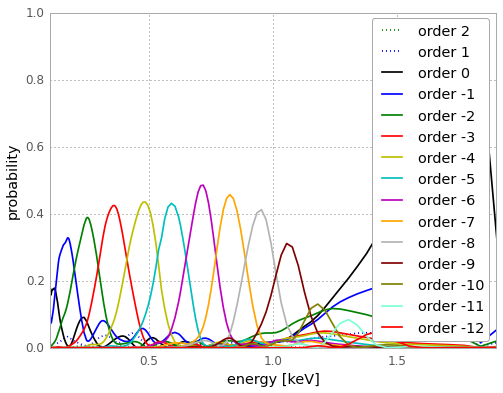

In [62]:
def wavelenght(energy):
    return energy / marxs.energy2wave

fig = plt.figure()
ax = fig.add_subplot(111)

color=['g:', 'b:', 'k', 'b','g','r','y', 'c','m','orange','0.7', 'maroon', 'olive', 'aquamarine', 'r', 'b']

for i, o in enumerate(gratingeff.orders):
    ax.plot(gratingeff.energy, gratingeff.prob[:, i], color[i], label='order {0}'.format(o))
ax.set_xlabel('energy [keV]')
ax.set_ylabel('probability')
#x.xaxis.set_scale('log')
ax.set_xlim([.1, 1.9])
ax.legend()

## Base line design

I use the following scenario as the baseline case here:

- Constant Pointing, no dither.
- Chandra mirror, using just the outer shell
- f = 9 m
- Blaze angle = 1.5 deg, Rowland torus rotated similar to Heilman et al. (2010)
- Gratings are 60 mm on the edge, grating edges are parallel to groove direction (so there is some empty space between gratings. That matters when we ask for the throughput, but for now I only calculate the spectral resolution).
- There is no alignment error.
- Grating constant = 2000 nm, efficiencies are from the file that Ralf gave me.
- Source is monochromatic, on-axis point source
- **No** sub-aperturing
- Detectors are flat. (From all I've seen we'll probably have flat detectors. I can simulate curved detectors, but
I don't think we are likely to have them and intersecting photons with a flat surface is just simpler.)
- For the calculation of the spectral resolution below the detector position is optimized numerically to achieve the best spectral resolution for each grating order and energy, however, I keep all detectors are perpendicular to the optical axis - they only move up and down. I've just not gotten around to rotate them properly to be tangent to the Rowland-torus. There is no reason that stops me from doing so, I just have not done it yet. I did cross-check that numerically optimizing the detector position gives numbers very similar to analytically solving the equation of the Rowland torus. 
- The detectors have infinitesimally small pixels.


## How does the simlated data look?

To give a first impression, I show a simulation for a monochromatic 1 keV on-axis point source with an infinite flat detector. The detector is centered on the imaging focus, so the dispersed orders are out of focus and look like an 8 for high orders.

In [63]:
mysource = PointSource((30., 30.), energy=1., flux=1.)

# make model for satellitw
mypointing = FixedPointing(coords=(30, 30.))
hrmafile = os.path.join(os.path.dirname(marxs.optics.__file__), 'hrma.par')
marxm = MarxMirror(hrmafile, position=numpy.array([0., 0,0]))
prune = lambda photons: photons[(photons['probability'] > 0)] # & (photons['mirror_shell'] == 0)]

blazeang = numpy.deg2rad(1.5)
blazemat = transforms3d.axangles.axangle2mat(numpy.array([0,1,0]), numpy.deg2rad(blazeang))
R, r, pos4d = design_tilted_torus(9e3, numpy.deg2rad(blazeang), numpy.deg2rad(2*blazeang))
mytorus = RowlandTorus(R, r, pos4d=pos4d)
mygas = GratingArrayStructure(mytorus, d_facet=80., x_range=[5e3,1e4], radius=[538., 550.],
                              elem_class=FlatGrating, 
                              elem_args={'zoom': 30, 'orientation': blazemat, 'd':0.0002, 
                                         'order_selector': gratingeff})
mydet = FlatDetector(zoom=1e4)
satellite = Sequence(sequence=[mypointing, marxm, prune, mygas, mydet])

photons = mysource.generate_photons(1e5)
photons = satellite(photons)

mysource02 = PointSource((30., 30.), energy=.2, flux=1.)
photons02 = mysource02.generate_photons(1e5)
photons02 = satellite(photons02)


In [17]:
# How many photons do we find in each grating order?
for o in np.arange(-10,3):
    ind = photons['order'] == o
    print 'Order {0} has {1} photons'.format(o, ind.sum())

Order -10 has 279 photons
Order -9 has 4646 photons
Order -8 has 9431 photons
Order -7 has 299 photons
Order -6 has 479 photons
Order -5 has 451 photons
Order -4 has 468 photons
Order -3 has 476 photons
Order -2 has 1264 photons
Order -1 has 508 photons
Order 0 has 488 photons
Order 1 has 433 photons
Order 2 has 222 photons


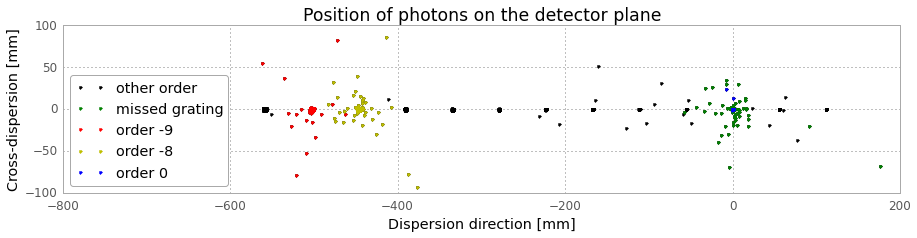

In [18]:
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(photons['det_y'], photons['det_x'], 'k.', label='other order')

ind = np.isnan(photons['order'])
ax.plot(photons['det_y'][ind], photons['det_x'][ind], 'g.', label='missed grating')

for i, c in zip([-9, -8, 0], 'ryb'):
    ind = photons['order'] == i
    ax.plot(photons['det_y'][ind], photons['det_x'][ind], c+'.', label='order {0}'.format(i))
ax.set_ylim([-100,100])
ax.set_xlim([-800, 200])
ax.set_xlabel('Dispersion direction [mm]')
ax.set_ylabel('Cross-dispersion [mm]')
ax.set_title('Position of photons on the detector plane')
plt.legend(loc='lower left')

<matplotlib.colorbar.Colorbar instance at 0x7ff03afb0488>

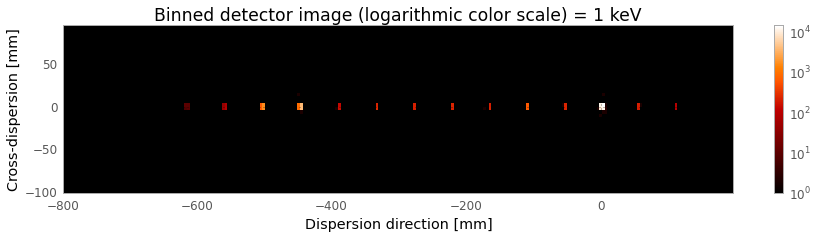

In [75]:
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(111, axisbg='k')
hist, edge1, edge2, image = ax.hist2d(photons['det_y'], photons['det_x'], 
                                      bins=[np.arange(-800, 200,4), np.arange(-100, 100,4)], 
                                      norm=mpl.colors.LogNorm())
ax.set_xlabel('Dispersion direction [mm]')
ax.set_ylabel('Cross-dispersion [mm]')
ax.set_title('Binned detector image (logarithmic color scale) = 1 keV')
plt.colorbar(image, ax=ax)

<matplotlib.colorbar.Colorbar instance at 0x7ff0636bc638>

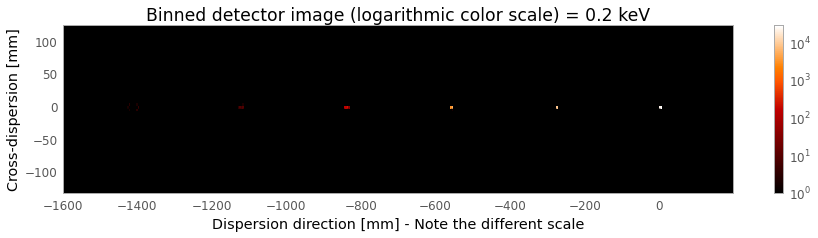

In [69]:
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(111, axisbg='k')
hist, edge1, edge2, image = ax.hist2d(photons02['det_y'], photons02['det_x'], 
                                      bins=[np.arange(-1600, 200,4), np.arange(-130, 130,4)], 
                                      norm=mpl.colors.LogNorm())
ax.set_xlabel('Dispersion direction [mm] - Note the different scale')
ax.set_ylabel('Cross-dispersion [mm]')
ax.set_title('Binned detector image (logarithmic color scale) = 0.2 keV')
plt.colorbar(image, ax=ax)

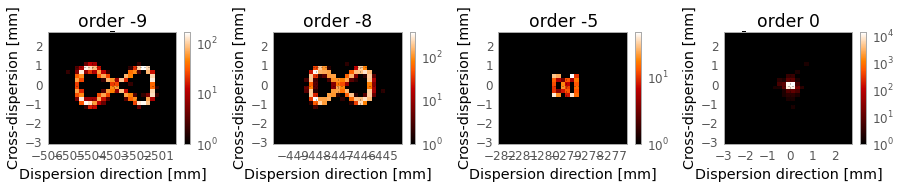

In [20]:
fig = plt.figure(figsize=(15,2))
d = 3
orders = [-9, -8, -5, 0]
binning = .2
for i, o in enumerate(orders):
    ind = photons['order'] == o
    xpos = np.median(photons['det_y'][ind])
    ax = fig.add_subplot(1, len(orders), i+1, axisbg='k')
    hist, edge1, edge2, image = ax.hist2d(photons['det_y'], photons['det_x'], 
                                      bins=[np.arange(xpos-d, xpos+d, binning), np.arange(-d, d, binning)], 
                                      norm=mpl.colors.LogNorm())
    plt.colorbar(image, ax=ax)
    ax.set_xlabel('Dispersion direction [mm]')
    ax.set_ylabel('Cross-dispersion [mm]')
    ax.set_title('order {0}'.format(o))
    
fig.subplots_adjust(wspace=0.4)

The four plots above give an impression how the photons fall onto the detector plane for a single, large flat detector that is positioned at the imaging focus, meaning that the grating orders are out of focus.
The first plot shows the position of every individual photon to give an impression of how they scatter. This scatter is dues to the micro-roughness on the Chandra mirror. Some specific grating orders are highlighted in color for orientation.
The second to forth plot show images as they are typically displayed in X-ray astronomy: Binned on the detector position and shown on a logarithmic scale. The second image shows an overview of the entire detector, the forth one zooms into individual orders in the 1 keV image. 

Comparing the secopnd and the third image, we see that the grating orders for low energy photons are spaced a lot further apart as expected fomr the grating equation. 

As the distance to the imaging focus increases from order 0 to order -9, the image becomes more and more defocussed. Note that order -9 is located about ~ 0.5 m  from the optical axis for 1 keV photons in this particular setup, so we expect order -9 for a 0.1 keV photon roughly 5 m out. Even with detectors that follow the Rowland circle, we would quickly reach the limits of spacecraft design. Fortunately, low-energy photons get scattered preferentially into low orders. Still, there is signal in the 0.2 keV simulation out to > 1.5 m from the optical axis - we would have to line up > 50 ACIS chips to cover all that distance.

## Measuring the FWHM

The number we are most interested in for now, is the spectral resolution a specific design can archieve and in the next major section I will calculate how the expected resolution changes with e.g. the misalignment of the facets on the grating array structure. Before I do so, I quickly want to demonstrat here, how I measure the spectral resolution.

First, we move the detector up and down to find the ideal focus position. (In reality, we will have a detector that more or less follows the Rowland circle, and I wil implement some form of that in the future, but for now I just use a single flat detector and move it up or down.) Then, we look at the distribution in the dispersion direction and measure the FWHM.

         Current function value: 0.064110
         Iterations: 5
         Function evaluations: 345
         Gradient evaluations: 109
FWHM is about 0.0643787239346
Spectral resolution is 6924.50620274


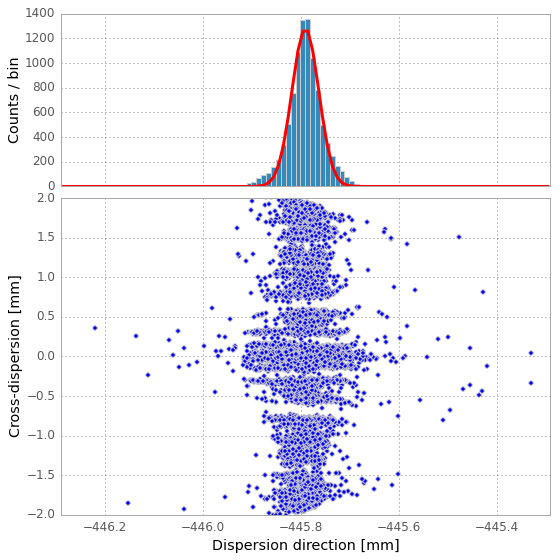

In [92]:
# Select the photons in grating order -8 only
p8 = photons[photons['order'] == -8]

# Find the optimal position of the detector ...
xbest = marxs.analysis.find_best_detector_position(p8, objective_func=marxs.analysis.measure_FWHM)
det = FlatDetector(position=np.array([xbest.x, 0, 0]), zoom=1e4)
# ... and intersect the photons with that detector
p8 = det(p8)

xpos = np.median(p8['det_y'])
w = .5
# For plotting purposes we want the dispersion direction on the horizontal axis
x = p8['det_y']
y = p8['det_x']


### Now the plot is made 
# definitions for the axes
left, width = 0.1, 0.85
bottom, height = 0.1, 0.55
bottom_h = left_h = left+height+0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.3]

# start with a rectangular Figure
plt.figure(1, figsize=(8,8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
nullfmt   = mpl.ticker.NullFormatter() # No labels
axHistx.xaxis.set_major_formatter(nullfmt)
axScatter.scatter(x, y)

# now determine nice limits by hand:
binwidth = 0.01
axScatter.set_xlim( (xpos - w, xpos + w) )
axScatter.set_ylim( (-2, 2) )
axScatter.set_xlabel('Dispersion direction [mm]')
axScatter.set_ylabel('Cross-dispersion [mm]')

bins = np.arange(xpos - w, xpos + w + binwidth, binwidth)
hist, bin_edges, patches = axHistx.hist(x, bins=bins)
axHistx.set_xlim( axScatter.get_xlim() )
axHistx.set_ylabel('Counts / bin')

bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2.
g_init = astropy.modeling.models.Gaussian1D(amplitude=hist.max(), mean=xpos, stddev=0.1)
fit_g = astropy.modeling.fitting.LevMarLSQFitter()
g = fit_g(g_init, bin_midpoints , hist)
axHistx.plot(bin_midpoints, g(bin_midpoints), lw=3., color='r')
print 'FWHM is about {0}'.format(2.3548 * g.stddev)
print 'Spectral resolution is {0}'.format(-xpos / (2.3548 * g.stddev))

The plot above shows again a zoom onto the detector. In the bottom panel, every detected event is indicates with a blue dot. The horizontal stripes with no photons correspond to areas of the Chandra mirror that are shaded by the mirror support structure. (Remember that we still talk about the baseline case, where all facets are perfectly aligned. In practice, small misalignments and the non-perfect resolution of the detector will smear out those gaps.)

*Note that the x and y scale on the image are not the same. This is purely for display purposes.*

The upper panel shows a histrogram of the event distribution on the detector. We now want to measure the energy resolution of this line. To do so, we need to measure the FWHM of the histogram. I chose to fit an analytical function (a Gaussian) to the histrigram and determine the FWHM from that. Looking at the plot, the real photon distribution is slightly narrower than my fit, so the FWHM quoated here might be a slight overestimatation. (*I don't like to read the FWHM off the histogram directly, because the value will depend strongly on the binning - at this stage of the affair this is not a detail to worry about.*)

To first order the FWHM in mm is linarly related to the FWHM in energy. So, we can extimate the resolution to ~ 7000 for this scenario (1 keV, order = -8, baseline design).

Now, if we look back that detector images above, we see that photons of 1 keV can be seen in many orders with the largest number in order -2, -8 and -9. To be precise, we should not say "the spectral resolution at 1 keV is", but alwayts say "The spectral resolution at 1 keV is x in order -9, is y in -8, z in -7, etc...". Unfortunately, that's very cumbersome to type every time. So, I am now introducing a way to summarize the different resolutions that we get in different orders for the same energy, following Heilman et al. (2010): I calculate the resolutions for each order as described above. Then I form the weighted average of the resolutions, weighting them by the number of photons that we see in each order, so that order -8 and -9 have a larger weight for 1 keV and order -4 and -5 have a very low weight.

This is an approximation I will discuss a little more below, but it greatly simplifies the plots in the following section.

## What spectral resolution do we expect?

When I say "spectral resolution", what I mean is this: Calculate the FWHM of the image of a grating order and the distance of the center of the order from the imaging focus. Since the extent of the every order is small, the FWHM of the photon distribution in detector coordiantes is essentially the same as the FWHM of the photon energy that would be assigned to each photon based on the grating equation. The position of the center of the photon distribution is equivalent to the photon energy.
So, the resolution is $\frac{FWHM_x}{x}\approx \frac{FWHM(energy)}{energy}$.
(Note that I use the linear distance. This slightly underestimates the total distance on the curved Rowland Torus and thus underestiamtes the spectral resolution. However, except for the very lowest energies and the very highest orders, the difference is negligable.)

The MARX Chandra mirror model applies a Gaussian blur to the photon direction to simulate the micro roughness. That means that for a large simulated number of photons, a few events will be found at a large distance from the center of the order. In a real instrument, they would blend in with the instrumental background. Thus, I apply a sigma-clipping before I calculate the FWHM and remove photons far from the instrumental position. (This also avoids numerical problems in fitting). Then, I fit a Gaussian to the remaining photon distribution in the dispersion direction. This allows me to get a number for the FWHM independend of the detector pixel size, which I don't know yet.


In [21]:
# make arrays for the energy grid and the orders we look at
orders = np.arange(-10, 0)
energies = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1., 1.5, 2.5, 5.])
n_photons = 1e4

# pass these numbers to the remote instances
dview['orders'] = orders
dview['n_photons'] = n_photons

### Baseline case

In [22]:
base = make_gas(blaze=1.5)
# pass object to the remote instances
dview['base'] = base

def run_base(energy):
    return run_res_sim(energy, gas=base, orders=orders, n_photons=n_photons)

base_result = dview.map_async(run_base, energies)

In [33]:
res = np.dstack(base_result.get(1))

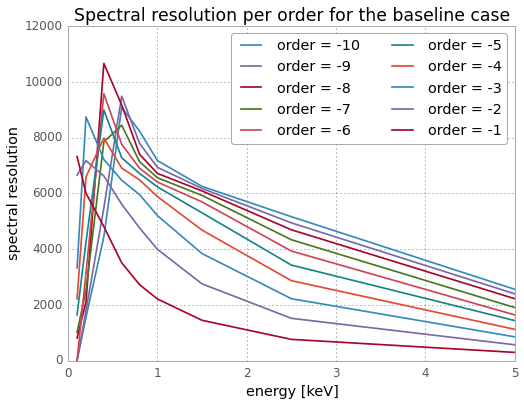

In [147]:
for i, o in enumerate(orders):
    out = plt.plot(energies, res[2, i, :], label='order = {0}'.format(o))
plt.legend(ncol=2)
plt.xlabel('energy [keV]')
plt.ylabel('spectral resolution')
plt.title('Spectral resolution per order for the baseline case')

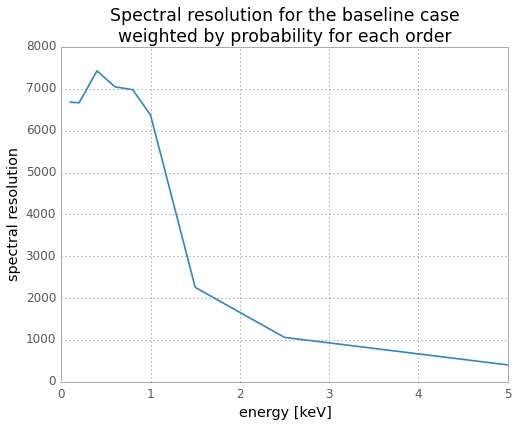

In [146]:
plt.plot(energies, weighted_per_order(res[2, :, :], orders, energies, gratingeff))
plt.xlabel('energy [keV]')
plt.ylabel('spectral resolution')
plt.title('Spectral resolution for the baseline case\nweighted by probability for each order')

The first plot above shows how the spectral resolution for each order depends on the energy. In practice, one (or a few) orders are strongly favoured for a specific energy. To capture this, the second plot shows the resolution averaged over all orders, weighted by the expected number of photons in each order.
For design purposes, this is a good number to look at as in Heilmann et al. (2010). 

In Chandra it is of course possible to do longer exposures and then extract a spectrum only from the third order, which has a higher resolution than the first order, but this is rarely useful, because so much more time would be required. Here, this strategy is even less likely to be employed, because the relative gain in resolution if very small if e.g. one was to expose long enough to use order -9 for a 1 keV signal, instead of -8 (where most 1 keV photons are seen).

**As explained above, in the current simulations all detectors are perpendicular to the optical axis, when really they should be rotated around the y axis to follow the Rowland Torus. I will fix this soon but for now, this manifests itself as an apparent drop in resolution for high orders and low energies.**

### Influence of alignment errors

In [23]:
# translation errors

trans_steps = [0., .1, .5, 1., 2., 5., 10.]
transx = [np.array([x, 0, 0]) for x in trans_steps]
transy = [np.array([0, x, 0]) for x in trans_steps]
transz = [np.array([0, 0, x]) for x in trans_steps]
trans = transx + transy + transz


def run_misalignment(energy, sigma_trans):
    gas = make_gas(blaze=1.5, sigma_trans=sigma_trans)
    return run_res_sim(energy, gas=gas, orders=orders, n_photons=n_photons)

trans_result_05 = dview.map_async(run_misalignment, [0.5] * len(trans), trans)
trans_result_10 = dview.map_async(run_misalignment, [1.0] * len(trans), trans)
trans_result_20 = dview.map_async(run_misalignment, [2.] * len(trans), trans)


In [24]:
# rotation errors
# define arcmin and convert to degree
rot_steps = np.array([0., 0.1, 0.25, 0.5, 1., 2., 5., 10., 30., 60., 120., 180.]) / 60.
rotx = [np.array([x, 0, 0]) for x in rot_steps]
roty = [np.array([0, x, 0]) for x in rot_steps]
rotz = [np.array([0, 0, x]) for x in rot_steps]
rot = rotx + roty + rotz


def run_misalignment(energy, sigma_rot):
    gas = make_gas(blaze=1.5, sigma_rot=sigma_rot)
    return run_res_sim(energy, gas=gas, orders=orders, n_photons=n_photons)

rot_result_05 = dview.map_async(run_misalignment, [0.5] * len(rot), rot)
rot_result_10 = dview.map_async(run_misalignment, [1.0] * len(rot), rot)
rot_result_20 = dview.map_async(run_misalignment, [2.] * len(rot), rot)


In [154]:
trans05 = np.dstack(trans_result_05.get(1))
trans10 = np.dstack(trans_result_10.get(1))
trans20 = np.dstack(trans_result_20.get(1))

In [120]:
rot05 = np.dstack(rot_result_05.get(1))
rot10 = np.dstack(rot_result_10.get(1))
rot20 = np.dstack(rot_result_20.get(1))
rot05.shape

(3, 10, 36)

In [103]:
def order_weights(order, energy):
    weights = np.zeros((len(order), len(energy)))
    for i, o in enumerate(orders):
        ind_o = (gratingeff.orders == o).nonzero()[0]
        if len(ind_o) != 1:
            raise KeyError('No data for order {0} in gratingeff'.format(o))
        en_sort = np.argsort(gratingeff.energy)
        weights[o, :] = np.interp(energy, gratingeff.energy[en_sort],
                                  gratingeff.prob[:, ind_o[0]][en_sort])

    return weights

In [121]:
my_weights = order_weights(orders, np.array([0.5, 1.0, 2.]))

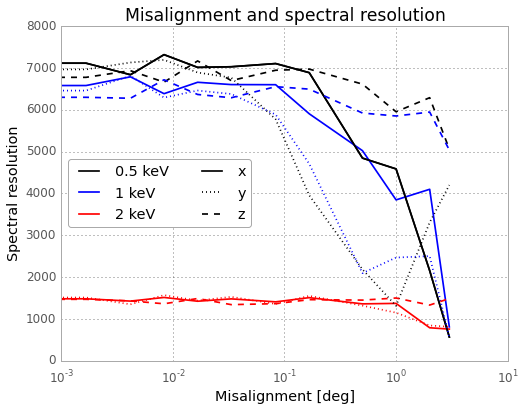

In [161]:
n = len(rot_steps)

i = 0
e1 = plt.plot(rot_steps, np.average(rot05[2, :, i*n: (i+1)*n], weights=my_weights[:, 0], axis=0), 'k-', label='0.5 keV')
e2 = plt.plot(rot_steps, np.average(rot10[2, :, i*n: (i+1)*n], weights=my_weights[:, 1], axis=0), 'b-', label='1 keV')
e3 = plt.plot(rot_steps, np.average(rot20[2, :, i*n: (i+1)*n], weights=my_weights[:, 2], axis=0), 'r-', label='2 keV')
# plot this a second time, so I can give it another label
l1 = plt.plot(rot_steps, np.average(rot05[2, :, i*n: (i+1)*n], weights=my_weights[:, 0], axis=0), 'k-', label='x')

i = 1
l2 = plt.plot(rot_steps, np.average(rot05[2, :, i*n: (i+1)*n], weights=my_weights[:, 0], axis=0), 'k:', label='y')
plt.plot(rot_steps, np.average(rot10[2, :, i*n: (i+1)*n], weights=my_weights[:, 1], axis=0), 'b:')
plt.plot(rot_steps, np.average(rot20[2, :, i*n: (i+1)*n], weights=my_weights[:, 2], axis=0), 'r:')

i = 2
l3 = plt.plot(rot_steps, np.average(rot05[2, :, i*n: (i+1)*n], weights=my_weights[:, 0], axis=0), 'k--', label='z')
plt.plot(rot_steps, np.average(rot10[2, :, i*n: (i+1)*n], weights=my_weights[:, 1], axis=0), 'b--')
plt.plot(rot_steps, np.average(rot20[2, :, i*n: (i+1)*n], weights=my_weights[:, 2], axis=0), 'r--')

plt.xscale('log')
plt.xlabel('Misalignment [deg]')
ax = plt.gca()
fig = plt.gcf()
ax.set_ylabel('Spectral resolution')
plt.title('Misalignment and spectral resolution')
out = plt.legend(ncol=2, loc='center left')

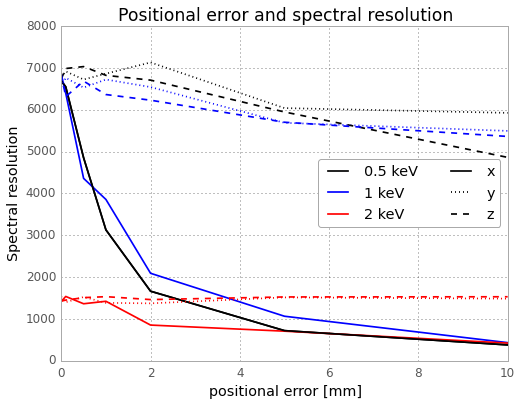

In [155]:
n = len(trans_steps)

i = 0
e1 = plt.plot(trans_steps, np.average(trans05[2, :, i*n: (i+1)*n], weights=my_weights[:, 0], axis=0), 'k-', label='0.5 keV')
e2 = plt.plot(trans_steps, np.average(trans10[2, :, i*n: (i+1)*n], weights=my_weights[:, 1], axis=0), 'b-', label='1 keV')
e3 = plt.plot(trans_steps, np.average(trans20[2, :, i*n: (i+1)*n], weights=my_weights[:, 2], axis=0), 'r-', label='2 keV')
# plot this a second time, so I can give it another label
l1 = plt.plot(trans_steps, np.average(trans05[2, :, i*n: (i+1)*n], weights=my_weights[:, 0], axis=0), 'k-', label='x')

i = 1
l2 = plt.plot(trans_steps, np.average(trans05[2, :, i*n: (i+1)*n], weights=my_weights[:, 0], axis=0), 'k:', label='y')
plt.plot(trans_steps, np.average(trans10[2, :, i*n: (i+1)*n], weights=my_weights[:, 1], axis=0), 'b:')
plt.plot(trans_steps, np.average(trans20[2, :, i*n: (i+1)*n], weights=my_weights[:, 2], axis=0), 'r:')

i = 2
l3 = plt.plot(trans_steps, np.average(trans05[2, :, i*n: (i+1)*n], weights=my_weights[:, 0], axis=0), 'k--', label='z')
plt.plot(trans_steps, np.average(trans10[2, :, i*n: (i+1)*n], weights=my_weights[:, 1], axis=0), 'b--')
plt.plot(trans_steps, np.average(trans20[2, :, i*n: (i+1)*n], weights=my_weights[:, 2], axis=0), 'r--')

plt.xlabel('positional error [mm]')
ax = plt.gca()
fig = plt.gcf()
ax.set_ylabel('Spectral resolution')
plt.title('Positional error and spectral resolution')
out = plt.legend(ncol=2, loc='center right')

The two plots above present a parameter study around the baseline case. Each grating in the grating array structure (GAS) is assigned a random rotation (upper plot) or translation (lower plot). The random values are drawn from a Gaussian distribution with the $\sigma$ (*not FWHM*) given on the x-axis of the plot. Each plot shows simulations for three discrete energies (0.5, 1 and 2 keV) and for each energy there is a rotation around or translation along the x,y, and z axis. Here x is parallel to the optical axis, y is the cross-dispersion direction, and z the dispersion direction.

The upper plot shows that rotations around the y direction (which corrspond to changes in the blaze angle) have the largest impact on the observed spectral resolution; the misalignment in this direction has be be kept below about 5 arcmin.

The lower plot shows the effect of translational offsets. In y and z direction an offset of several mm is still acceptable, but in x direction (along the optical axis) the position has to be accuarate to better than 0.5 mm. Note that this refers to the relative position of individual facets, not the placement of the GAS as a whole. If all facets are displaced up or down together, the position of the grating focus changes - this can be mostly mitigated by moving the detector up or down. However, if facets are displaced individually, essentially each facet has a different focus point and the detector must be placed at the average of those, leading to a blurred image and thus a reduced spectral resolution.

In practice, each grating facet will of course have both rotational and translational offsets with respect to te nominal position, but the analysis here shows which are most important error sources.

For each simulation shown in this section a large number of photons was generated and traced for every spectral order and the weighted average of the resolution was calculated as above. However, each simulation used only a single realization of the GAS. The GASs in these examples have about 40 facets - enough to ensure that none of the realizations is a perfect GAS by chance, but not enough to ensure one GAS may not be better than another with a nominally larger $\sigma$. This explains some of the wiggles in the curves.

In [ ]:
# Format output for Glue
# output non-vector columns
pout = p[:]
for c in p.colnames:
    if len(p[c].shape) > 1:
        pout.remove_column(c)

# output facet information
facet = np.arange(len(mygas.elements))
facet_tab = astropy.table.Table({'facet':facet, 'facet_x': facet, 'facet_y': facet, 'facet_z':facet})
for i in facet:
    facet_tab['facet_x'][i] = mygas.elements[i].pos4d[0, 3]
    facet_tab['facet_y'][i] = mygas.elements[i].pos4d[1, 3]
    facet_tab['facet_z'][i] = mygas.elements[i].pos4d[2, 3]

photfac = astropy.table.join(pout, facet_tab)
photfac.write('xraysurveyor.fits', overwrite=True)